# Explain

* Test SEMIC in cpp version, compare to original CODE (Krapp et al., 2017)

# References

* Krapp, M., Robinson, A., and Ganopolski, A.: SEMIC: an efficient surface energy and mass balance model applied to the Greenland ice sheet, The Cryosphere, 11, 1519–1535, https://doi.org/10.5194/tc-11-1519-2017, 2017.

# Load modules

In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pyseb

import xarray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# transet station from Krapp et al. (2017)

* Dataset format in `transect_input.txt`.

    * snow fall rate [m/s]
    * rain fall rate [m/s]
    * downwelling shortwave radiation [W/m2]
    * downwelling longwave radiation [W/m2]
    * surface wind speed [m/s]
    * surface pressure [Pa]
    * air density [kg/m3]
    * air specific humidity [kg/kg]
    * air temperature [K]
 
* Validataion data format in `transect.nc`.
    * 

In [28]:
print("Load SEMIC-ISSM results")
# alb_scheme = 'Slater'
alb_scheme = 'Denby'
# alb_scheme = 'Isba'
nc = xarray.load_dataset('../data/SEMIC-ISSM/test_semic_transect_Alb%s.nc'%(alb_scheme))

display(nc)

Load SEMIC-ISSM results


<xarray.Dataset> Size: 126kB
Dimensions:  (nx: 7, time: 365)
Coordinates:
  * nx       (nx) int64 56B 0 1 2 3 4 5 6
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    smb      (time, nx) float64 20kB 0.09099 0.1111 0.09898 ... 0.0616 0.05749
    melt     (time, nx) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    hsnow    (time, nx) float64 20kB 0.06239 0.0597 0.0892 ... 0.206 3.301
    tsurf    (time, nx) float64 20kB 241.2 245.2 252.9 ... 241.3 241.1 240.5
    alb      (time, nx) float64 20kB 0.7389 0.7317 0.7827 ... 0.8097 0.8097 0.81
    subl     (time, nx) float64 20kB -0.08344 -0.1019 ... -0.05649 -0.05272

In [29]:
print("Load 'transect' dataset.")
# inputs  = np.loadtxt('../data/SEMIC-Krapp2017/c01_input.txt')
# valid   = np.loadtxt('../data/SEMIC-Krapp2017/c01.out')

inputs  = np.loadtxt('../data/SEMIC-Krapp2017/transect_input.txt')
valid   = np.loadtxt(f'../data/SEMIC-Krapp2017/transect_output_{alb_scheme.lower()}.txt')

ntime = np.shape(inputs)[0]

print(np.shape(inputs))

Load 'transect' dataset.
(365, 63)


In [30]:
try:
    del semic
except:
    pass
try:
    del forc
except:
    pass

print('Initialize semic module.')
semic = pyseb.SEMIC()
nx = 7
ONES = np.ones((nx,))

print(f'   number of thread = {semic.num_threads}')

# initialize semic module
semic.Initialize(nx)

print("Initialize SEMIC forcing class.")
forc = pyseb.SemicForcings(nx, ntime)
print(f'   forc.nx    = {forc.nx}')
print(f'   forc.ntime = {forc.ntime}')

sf   = inputs[:,0*nx:1*nx].T
rf   = inputs[:,1*nx:2*nx].T
swd  = inputs[:,2*nx:3*nx].T
lwd  = inputs[:,3*nx:4*nx].T
wind = inputs[:,4*nx:5*nx].T
sp   = inputs[:,5*nx:6*nx].T
rhoa = inputs[:,6*nx:7*nx].T
qq   = inputs[:,7*nx:8*nx].T
t2m  = inputs[:,8*nx:9*nx].T

# sf    = np.tile(sf, (nx,1))
# rf    = np.tile(rf, (nx,1))
# swd   = np.tile(swd, (nx,1))
# lwd   = np.tile(lwd, (nx,1))
# wind  = np.tile(wind, (nx,1))
# sp    = np.tile(sp, (nx,1))
# rhoa  = np.tile(rhoa, (nx,1))
# qq    = np.tile(qq, (nx,1))
# t2m   = np.tile(t2m, (nx,1))

forc.sf.set_value(sf)
forc.rf.set_value(rf)
forc.swd.set_value(swd)
forc.lwd.set_value(lwd)
forc.wind.set_value(wind)
forc.sp.set_value(sp)
forc.rhoa.set_value(rhoa)
forc.qq.set_value(qq)
forc.t2m.set_value(t2m)

outputs = {}
outputs['tsurf']      = valid[:,0*nx:1*nx]
outputs['alb']        = valid[:,1*nx:2*nx]
outputs['swd(1-alb)'] = valid[:,2*nx:3*nx]
outputs['smb']        = valid[:,3*nx:4*nx]
outputs['melt']       = valid[:,4*nx:5*nx]
outputs['acc']        = valid[:,5*nx:6*nx]
outputs['shf']        = valid[:,6*nx:7*nx]
outputs['lhf']        = valid[:,7*nx:8*nx]
outputs['hsnow']      = valid[:,8*nx:9*nx]


semic.mask = [1,1,1,2,2,2,2] # ice part
semic.verbose = 0

if alb_scheme == 'Slater':
    semic.alb_scheme = 1 # Slater's albedo scheme
elif alb_scheme == 'Denby':
    semic.alb_scheme = 2 # Denby's albedo scheme
else:
    semic.alb_scheme = 0 # None albedo scheme


print(f'Set Parameters')
semic.Param.alb_smax = 0.81
semic.Param.alb_smin = 0.60
semic.Param.albi = 0.41
semic.Param.albl = 0.15
semic.Param.tmax = 273.15
semic.Param.tmin = 273.15-10
semic.Param.rcrit = 0.79
semic.Param.hcrit = 0.028
semic.Param.mcrit = 6e-8
semic.Param.amp = 3.5*ONES[:]

print(f'Initialize default value in SEMIC')
semic.alb   = 0.80*ONES[:]
semic.alb_snow = 0.80*ONES[:]
semic.hsnow = 5.*ONES[:]
semic.hice  = 10.*ONES[:]

print(f'   -- set initial surface temperature (K)')
semic.tsurf = 260*ONES[:]

print(f'   mask:  {semic.mask}')
print(f'   ntime: {ntime}')

semic.output_request = ['smb', 'melt', 'alb', 'tsurf', 'hsnow','subl','evap']
print(f'   requested output = {semic.output_request}')

nloop = 20
print('Run SEMIC')
# semic.debug = 1
semic.verbose = 0
semic.RunEnergyAndMassBalance(forc,nloop)
print('done')

print(f'   Return output')
tsurf = semic.Result.tsurf.get_value()
smb   = semic.Result.smb.get_value()
alb   = semic.Result.alb.get_value()
melt  = semic.Result.melt.get_value()
hsnow = semic.Result.hsnow.get_value()
subl  = semic.Result.subl.get_value()
evap  = semic.Result.evap.get_value()

# del semic
# del forc

Initialize semic module.
   number of thread = 1
Initialize SEMIC forcing class.
   forc.nx    = 7
   forc.ntime = 365
Set Parameters
Initialize default value in SEMIC
   -- set initial surface temperature (K)
   mask:  [1, 1, 1, 2, 2, 2, 2]
   ntime: 365
   requested output = ['smb', 'melt', 'alb', 'tsurf', 'hsnow', 'subl', 'evap']
Run SEMIC
done
   Return output


# Check tolerance between benchmark test.

In [31]:
rho_ice = 917 # kg m-3
rho_freshwater = 1000 # kg m-3
yts = 365*24*3600

#                 tsurf, smb 
ref_difference = [[0.262365352887259, 0.17525897487509795],
                 [0.25444378256132016, 0.1448544866931223],
                 [0.2829541919649512, 0.1720996367990658],
                 [0.12063467291458232, 0.235235881267827],
                 [0.06591790359727247, 0.264646605327009],
                 ]
ref_difference = np.array(ref_difference)

for stnid in range(5):
    print(f'Check station id = {stnid}')
    tsurf1 = nc['tsurf'].values[:,stnid] # from SEMIC-ISSM
    tsurf2 = tsurf[stnid].ravel() # from SEMIC-cpp

    diff_tsurf = np.abs(tsurf1-tsurf2).mean()
    print(f'-- tsurf diff = {diff_tsurf}')
    
    smb1 = nc['smb'].values[:,stnid] # from SEMIC-ISSM
    smb2 = smb[stnid].ravel()*yts*rho_freshwater/rho_ice # from SEMIC-cpp
    
    diff_smb = np.abs(smb1-smb2).mean()
    print(f'-- smb diff  = {diff_smb}')

    # check tolerance
    assert (abs(ref_difference[stnid][0] - diff_tsurf) < 0.0001), 'ERROR: given diff_tsurf tolerance > 0.0001'
    assert  (abs(ref_difference[stnid][1] - diff_smb) < 0.0001), 'ERROR: given diff_smb tolerance > 0.0001'

Check station id = 0
-- tsurf diff = 0.262365352887259
-- smb diff  = 0.17525897487509795
Check station id = 1
-- tsurf diff = 0.25444378256132016
-- smb diff  = 0.1448544866931223
Check station id = 2
-- tsurf diff = 0.2829541919649512
-- smb diff  = 0.1720996367990658
Check station id = 3
-- tsurf diff = 0.12063467291458232
-- smb diff  = 0.235235881267827
Check station id = 4
-- tsurf diff = 0.06591790359727247
-- smb diff  = 0.264646605327009


# Check variables

* Check calculated surface variables.
    * Surface temperature
    * SMB
    * Albedo
    * Melt
    * Hsnow - snow height
 
* Experiment
    * `SEMIC-cpp`: data from `SEMIC-cpp` code
    * `Validation`: data from original `SEMIC` of Krapp et al. (2017).
    * `SEMIC-ISSM`: data from SEMIC implemented in `ISSM`.

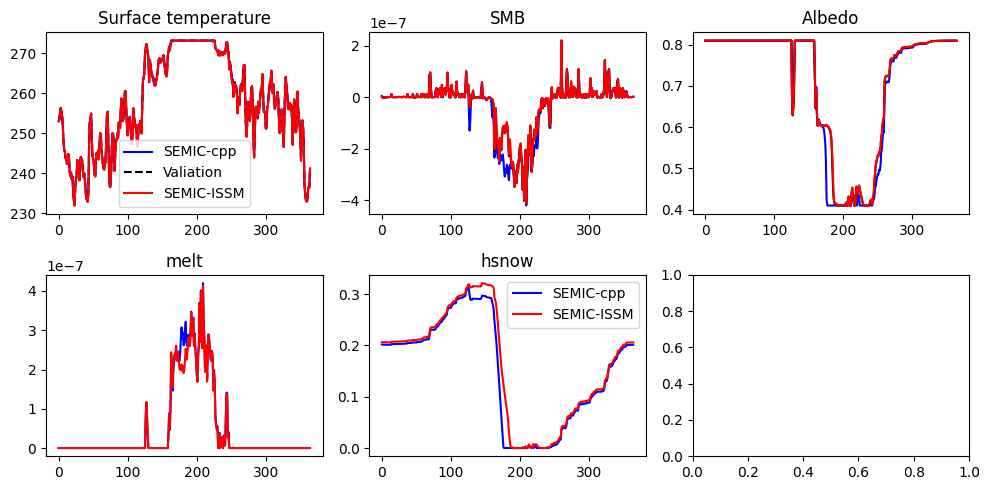

In [9]:
rho_ice = 917 # kg m-3
rho_freshwater = 1000 # kg m-3
yts = 365*24*3600
stnid = 5

fig, axs = plt.subplots(2,3,figsize=(10,5))
axs = axs.flatten()

ax = axs[0]
ax.plot(np.arange(ntime), tsurf[stnid].ravel(), label='SEMIC-cpp', color='b')
ax.plot(np.arange(ntime), outputs['tsurf'][:,stnid], label='Valiation', ls='--', color='k')
ax.plot(nc.time, nc['tsurf'].values[:,stnid], label='SEMIC-ISSM', ls='-', color='r')
ax.set_title('Surface temperature')

ax = axs[1]
ax.plot(np.arange(ntime), smb[stnid].ravel(), label='SEMIC-cpp', color='b')
ax.plot(np.arange(ntime), outputs['smb'][:,stnid], label='Valiation', color='k')
ax.plot(nc.time, nc['smb'].values[:,stnid]/yts*rho_ice/rho_freshwater, label='SEMIC-ISSM', ls='-', color='r')
ax.set_title('SMB')

ax = axs[2]
ax.plot(np.arange(ntime), alb[stnid].ravel(), label='SEMIC-cpp', color='b')
ax.plot(np.arange(ntime), outputs['alb'][:,stnid], label='Valiation', color='k')
ax.plot(nc.time, nc['alb'].values[:,stnid], label='SEMIC-ISSM', ls='-', color='r')
ax.set_title('Albedo')

ax = axs[3]
ax.plot(np.arange(ntime), melt[stnid].ravel(), label='SEMIC-cpp', color='b')
ax.plot(nc.time, nc['melt'].values[:,stnid]/yts*rho_ice/rho_freshwater, label='SEMIC-ISSM', ls='-', color='r')
ax.set_title('melt')

ax = axs[4]
ax.plot(np.arange(ntime), hsnow[stnid].ravel(), label='SEMIC-cpp', color='b')
# ax.plot(np.arange(ntime), outputs['hsnow'][:,stnid], label='Valiation', color='k')
ax.plot(nc.time, nc['hsnow'].values[:,stnid], label='SEMIC-ISSM', ls='-', color='r')
ax.set_title('hsnow')
ax.legend()

axs[0].legend()

fig.tight_layout()
fig.savefig('Graphics/test_SemicStation_Fig1.png')

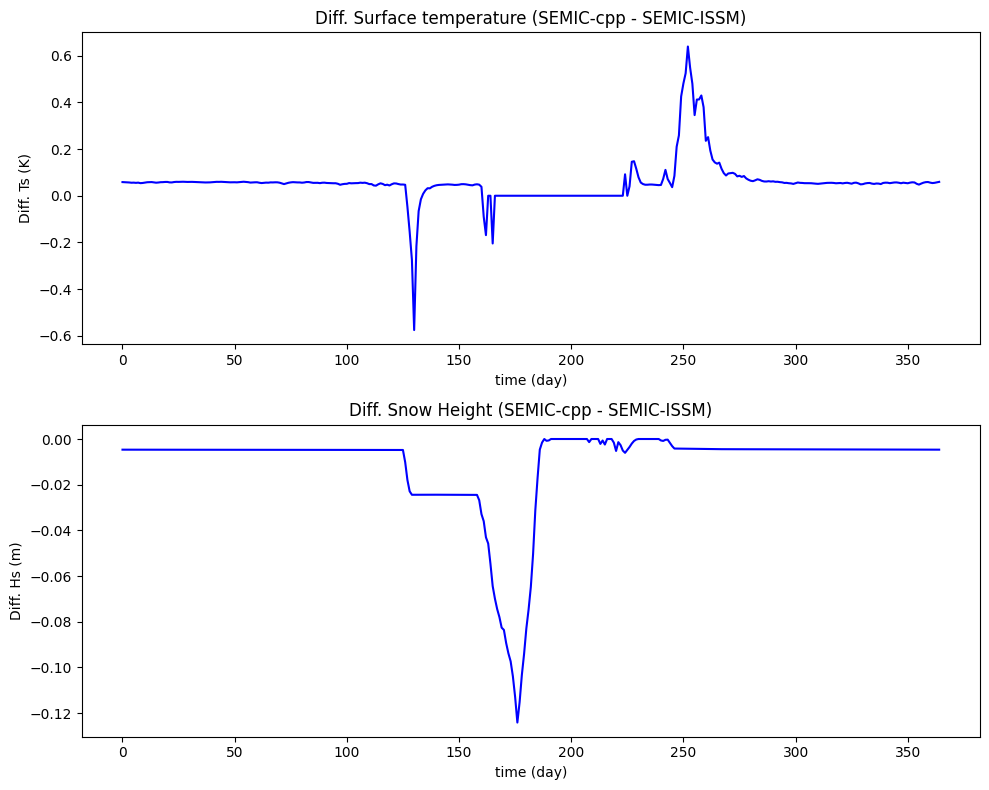

In [6]:
fig, axs = plt.subplots(2,1,figsize=(10, 8))
axs = axs.flatten()

ax = axs[0]
ax.plot(np.arange(ntime), tsurf[stnid].ravel()-nc['tsurf'].values[:,stnid],
        label='SEMIC-cpp', color='b')
ax.set_title('Diff. Surface temperature (SEMIC-cpp - SEMIC-ISSM)')
ax.set_xlabel('time (day)')
ax.set_ylabel('Diff. Ts (K)')

ax = axs[1]
ax.plot(np.arange(ntime), hsnow[stnid].ravel()-nc['hsnow'].values[:,stnid],
        label='SEMIC-cpp', color='b')
ax.set_title('Diff. Snow Height (SEMIC-cpp - SEMIC-ISSM)')
ax.set_xlabel('time (day)')
ax.set_ylabel('Diff. Hs (m)')

fig.tight_layout()
fig.savefig('Graphics/test_SemicStation_Fig2.png')

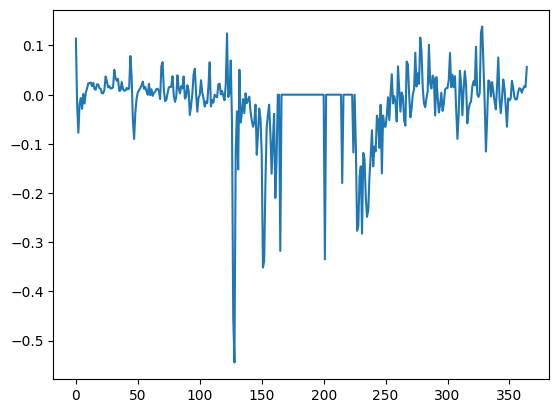

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(ntime), subl[stnid].ravel()-nc['subl'].values[:,stnid],)
fig.savefig('Graphics/test_SemicStation_Fig3.png')